<AxesSubplot:xlabel='Date'>

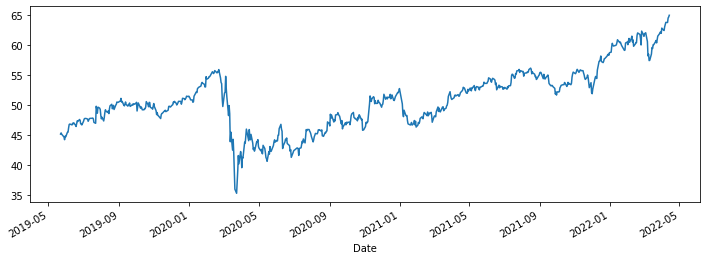

In [1]:
#!pip install yfinance
import yfinance as yf
tickerS = "KO"
tickerData = yf.Ticker(tickerS)
tickerDf = tickerData.history(start = '2019-05-23', end = '2022-04-17', interval="1d", actions=False)
tickerDf.Close.plot(figsize=(12, 4))

In [2]:
def traiding(high_train, low_train, high_test, low_test, close, l):
    all_profit = 0
    profit = 0
    pos = False
    num_steps = len(close)
    deals = []
    comission = 0.04
    for step in range(num_steps):
        buy_price = low_train[step]*l
        sell_price = high_train[step]*l
        if buy_price >= low_test[step]:
            pos = True
            profit -= comission /100 * buy_price
        if pos:
            if sell_price <= high_test[step]:
                p = sell_price-buy_price
                status = 'succes'
                #print("_________________________________________________________")
            else:
                sell_price = close[step]
                p = sell_price*(1-comission/100)-buy_price
                if p<=0:
                    status = 'failed'
                else:
                    status = 'ыбыбыб'
            profit += p
            pos = False
            deals.append({'status' : status, 'buy_price' : buy_price, 'sell_price' : sell_price, 'profit' : p})
    return deals

In [3]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

def regressor(high, prediction_columns):
    x = high[prediction_columns[1:]]#.values
    y = high[prediction_columns[0]]#.values.reshape(-1,1)
    high_x_train, high_x_test, high_train, high_test = train_test_split(x, y, test_size=0.33, random_state = 42, shuffle = False)
    catboost_high = DecisionTreeRegressor()
    catboost_high.fit(high_x_train, high_train)
    return catboost_high, high_x_test, high_test

def inversion(a, high_min, lambda_high, high1):
    inv_high_test_from_minmax_to_diff = inv_minmax(a.reshape(-1,1), high_min)
    inv_high_test_from_diff_to_boxcox = inv_diff(high1, inv_high_test_from_minmax_to_diff.reshape(-1))
    #inv_high_test_from_diff_to_boxcox = inv_diff(high1, a.reshape(-1))
    inv_high_test = inv_boxcox(inv_high_test_from_diff_to_boxcox.reshape(-1), lambda_high)
    return inv_high_test

def boxcoxMy(data, columnOld, columnNew):
    trans, lambda_ = boxcox(data[columnOld].values)
    data[columnNew] = trans
    return lambda_

def inv_boxcoxMyforLag(data, lambda_, columnOld, columnNew):
    #data[columnNew] = inv_boxcox(data[columnOld].values, lambda_)
    #data[columnNew].plot()
    data[columnOld] = inv_boxcox(data[columnOld].values, lambda_)
    
def inv_box_cox(data, lambda_):
    return inv_boxcox(data, lambda_)
    
def diff(data, columnOld, columnNew):
    data[columnNew] = data[columnOld].diff()
    #data[columnNew].plot()
    
def inv_diff(high1, high_test):
    return high1[len(high1) - len(high_test)-1:-1]+high_test

def anotherDiff(data, columnOld, columnNew):
    data[columnNew] = data[columnOld].pct_change()
    #data[columnNew].plot()

def minmax(data, columnOld, columnNew):
    scaler = MinMaxScaler()
    data[columnNew] = scaler.fit_transform(data[columnOld].values.reshape(-1,1))
    #data[columnNew].plot()
    return scaler.fit(data[columnOld].values.reshape(-1,1))

def inv_minmax(data, obj):
    #scaler = MinMaxScaler()
    #scaler = scaler.fit(data[columnOld].values.reshape(-1,1))
    #data[columnNew] = scaler.inverse_transform(data[columnOld].values.reshape(-1,1))
    #data[columnOld] = scaler.inverse_transform(data[columnOld].values.reshape(-1,1))
    return obj.inverse_transform(data).reshape(-1,1)
    
def lag_fich(data, prediction_columns):
    for i in range(1, prediction_window+1):
        col_name = f'shift_{i}'
        prediction_columns.append(col_name)
        data[col_name] = data[prediction_columns[0]].shift(i)
    #data.plot()
    return data[prediction_columns].dropna()

def metrics(inv_high_x, inv_high_test):
    from sklearn.metrics import mean_squared_error
    print('mean_squared_error', mean_squared_error(inv_high_x,inv_high_test))

    from sklearn.metrics import mean_absolute_error
    print('mean_absolute_error',mean_absolute_error(inv_high_test, inv_high_x))

    from sklearn.metrics import mean_absolute_percentage_error
    print('mean_absolute_percentage_error',mean_absolute_percentage_error(inv_high_test, inv_high_x))

In [4]:
lag = 10

low = tickerDf.copy()
high = tickerDf.copy()
close = tickerDf.copy()

lambda_high = boxcoxMy(high, 'High', 'boxcox')
lambda_low = boxcoxMy(low, 'Low', 'boxcox')
#lambda_close =boxcoxMy(close, 'Close', 'boxcox')
high1 = high['boxcox'].values[lag:].copy()
low1 = low['boxcox'].values[lag:].copy()

diff(high, 'boxcox', 'diff')
diff(low, 'boxcox', 'diff')
#diff(close, 'boxcox', 'diff')
#anotherDiff(close, 'Close', 'anotherDiff')
high_min = minmax(high, 'diff', 'minmax_scaler')
low_min = minmax(low, 'diff', 'minmax_scaler')
#minmax(close, 'boxcox', 'minmax_scaler')

In [5]:
high1.shape

(722,)

In [6]:
prediction_window = lag
prediction_columns = ['Close']
close = lag_fich(close, prediction_columns)

prediction_window = lag
prediction_columns = ['minmax_scaler']
high = lag_fich(high, prediction_columns)
prediction_window = lag
prediction_columns = ['minmax_scaler']
low = lag_fich(low, prediction_columns)

In [7]:
high

,minmax_scaler,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10
Date,,,,,,,,,,,
2019-06-07,0.639030,0.607876,0.669074,0.596204,0.646638,0.556246,0.594503,0.469220,0.526672,0.554905,0.581771
2019-06-10,0.473462,0.639030,0.607876,0.669074,0.596204,0.646638,0.556246,0.594503,0.469220,0.526672,0.554905
2019-06-11,0.562662,0.473462,0.639030,0.607876,0.669074,0.596204,0.646638,0.556246,0.594503,0.469220,0.526672
2019-06-12,0.626293,0.562662,0.473462,0.639030,0.607876,0.669074,0.596204,0.646638,0.556246,0.594503,0.469220
2019-06-13,0.551639,0.626293,0.562662,0.473462,0.639030,0.607876,0.669074,0.596204,0.646638,0.556246,0.594503
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-08,0.591015,0.595086,0.558148,0.599276,0.540900,0.586026,0.597877,0.525229,0.613597,0.588638,0.614733
2022-04-11,0.580520,0.591015,0.595086,0.558148,0.599276,0.540900,0.586026,0.597877,0.525229,0.613597,0.588638
2022-04-12,0.603487,0.580520,0.591015,0.595086,0.558148,0.599276,0.540900,0.586026,0.597877,0.525229,0.613597


In [8]:
regressor_high, high_x_test, high_test = regressor(high, prediction_columns)

<AxesSubplot:>

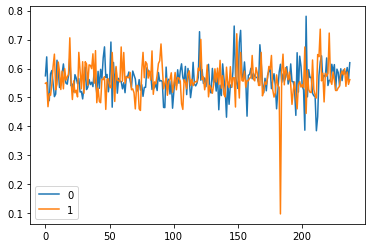

In [9]:
import pandas as pd
df = pd.DataFrame([high_test.values, regressor_high.predict(high_x_test)]).T
df.plot()

In [10]:
inv_high_test = inversion(high_test.values, high_min, lambda_high, high1)
inv_high_x = inversion(regressor_high.predict(high_x_test), high_min, lambda_high, high1)
#inv_high_test = inversion(high_test.values, high1, high1, high1)
#inv_high_x = inversion(regressor_high.predict(high_x_test), high1, high1, high1)

<AxesSubplot:xlabel='Date', ylabel='Price $'>

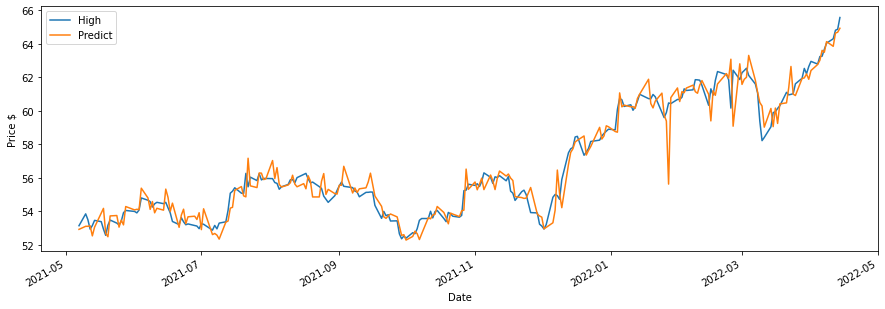

In [11]:
df = pd.DataFrame([tickerDf['High'][-len(inv_high_x):]]).T
df['Predict'] = inv_high_x
df[:].plot(ylabel='Price $',figsize=(15,5))

<AxesSubplot:xlabel='Date', ylabel='Price $'>

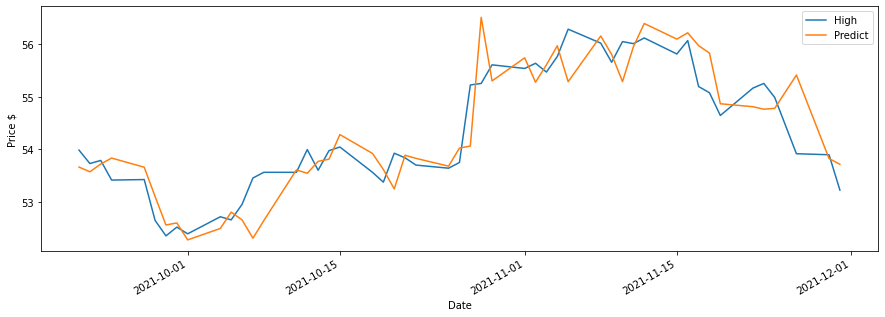

In [12]:
df = pd.DataFrame([tickerDf['High'][-len(inv_high_x):]]).T
df['Predict'] = inv_high_x
df[-len(inv_high_x)//2-25:-len(inv_high_x)//2+25].plot(ylabel='Price $',figsize=(15,5))

In [13]:
metrics(inv_high_x, inv_high_test)

mean_squared_error 0.5569623670202761
mean_absolute_error 0.504519130195293
mean_absolute_percentage_error 0.008852313470861477


In [14]:
regressor_low, low_x_test, low_test = regressor(low, prediction_columns)

<AxesSubplot:>

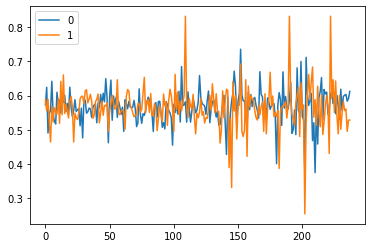

In [15]:
df = pd.DataFrame([low_test.values, regressor_low.predict(low_x_test)]).T
df.plot()

In [16]:
inv_low_test = inversion(low_test.values, low_min, lambda_low, low1)
inv_low_x = inversion(regressor_low.predict(low_x_test), low_min, lambda_low, low1)
#inv_low_test = inversion(low_test.values, low1, low1, low1)
#inv_low_x = inversion(regressor_low.predict(low_x_test), low1, low1, low1)

In [17]:
metrics(inv_low_x, inv_low_test)

mean_squared_error 0.5984910143767121
mean_absolute_error 0.5721258320556779
mean_absolute_percentage_error 0.010176125219093652


<AxesSubplot:>

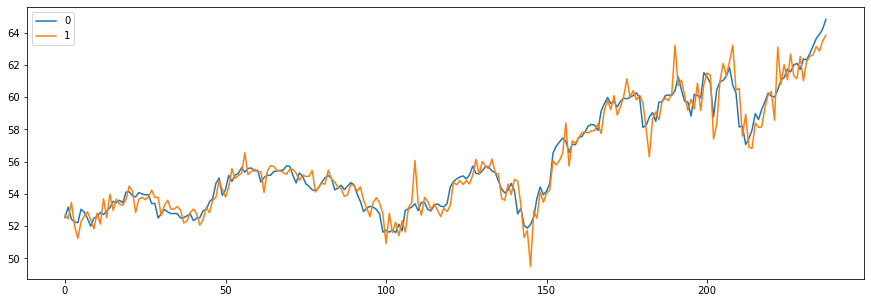

In [18]:
df = pd.DataFrame([inv_low_test, inv_low_x]).T
df.plot(figsize=(15,5))

In [19]:
l = 1
deals = traiding(inv_high_x, inv_low_x, inv_high_test, inv_low_test, close.Close.iloc[len(high1) - len(high_test):].values, l)
print('profit =', sum([i['profit'] for i in deals]))
deals

profit = -21.256320326560235


[{'status': 'succes',
  'buy_price': 52.707657946727615,
  'sell_price': 52.91492185634861,
  'profit': 0.20726390962099828},
 {'status': 'succes',
  'buy_price': 53.473246280873674,
  'sell_price': 53.09704476752361,
  'profit': -0.37620151335006113},
 {'status': 'failed',
  'buy_price': 52.88953212845355,
  'sell_price': 52.71417999267578,
  'profit': -0.1964378077748421},
 {'status': 'ыбыбыб',
  'buy_price': 52.389902251902335,
  'sell_price': 52.549259185791016,
  'profit': 0.1383372302143684},
 {'status': 'ыбыбыб',
  'buy_price': 52.80828841546833,
  'sell_price': 52.98579788208008,
  'profit': 0.15631514745891906},
 {'status': 'succes',
  'buy_price': 53.694855248363545,
  'sell_price': 53.04658611132528,
  'profit': -0.6482691370382625},
 {'status': 'succes',
  'buy_price': 53.9931189240876,
  'sell_price': 53.18199882074203,
  'profit': -0.8111201033455657},
 {'status': 'failed',
  'buy_price': 53.67363451165378,
  'sell_price': 53.62605285644531,
  'profit': -0.069032076351042

In [20]:
print(f"{str(deals).count('succes')}/{len(deals)} successesful deals")

43/105 successesful deals
